# Self-supervised FCNs for Monocular Depth-estimation
##### *Oliver Tattersall (omtatter@uwaterloo.ca), Owen Waldron (orpwaldr@uwaterloo.ca)*



Plan:
1. read some more papers and find all the datasets
  a) we can use resnet50 as encoder, and then I think we build a more complicated decoder
2. try to see if we can get an overfitted model to work
3. try to see if we can extend that model
4. Great Success


## Abstract

TODO

## Team Members & Contributions

- Oliver Tattersall (omtatter@uwaterloo.ca)
    - Loss Functions, Training Loop
- Owen Waldron (orpwaldr@uwaterloo.ca)
    - Data Synthesis, Model


## Code Libraries

In [202]:

import random # Used in data augmentation
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries.
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
from torchvision.datasets._stereo_matching import Kitti2015Stereo
import torchvision.models as models
from torchmetrics.image import StructuralSimilarityIndexMeasure

## Data Synthesis

We will be using the [KITTI stereo dataset](https://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo) for stereo disparity pairs. 

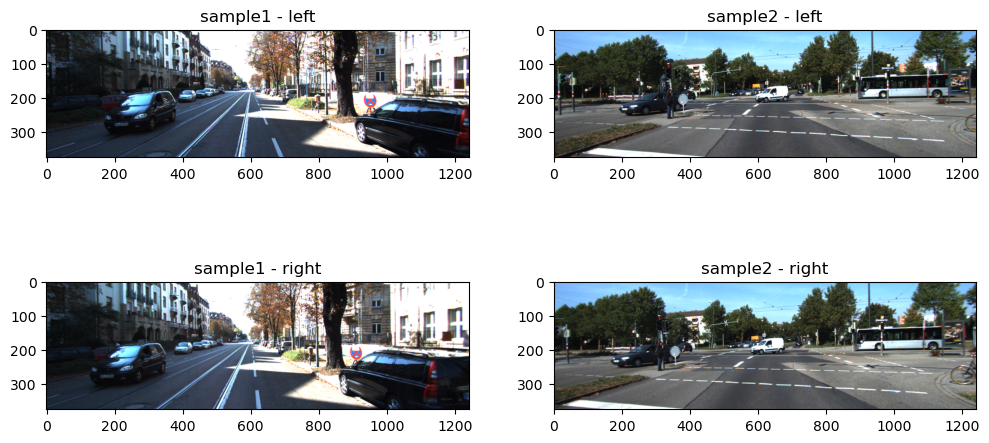

In [141]:
# Importing the KITTY dataset

DATASET_PATH = 'datasets'

# Create a dataloader to load in images
sample1 = Kitti2015Stereo(DATASET_PATH)[0]
sample2 = Kitti2015Stereo(DATASET_PATH)[15]

left1, right1 = sample1[0:2]
left2, right2 = sample2[0:2]

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - left')
ax1.imshow(left1)
ax2 = fig.add_subplot(2,2,3)
plt.title('sample1 - right')
ax2.imshow(right1)
ax3 = fig.add_subplot(2,2,2)
plt.title('sample2 - left')
ax3.imshow(left2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - right')
ax4.imshow(right2)


To augment training data, we first prepare the following transformations that follow the `StereoMatchingDataset` API. Note that that `StereoMatchingDataset` applies the transformations to the left & right images, as well as the disparities & valid_masks. These last two aren't used in training, so we do not bother transforming them in our `RandomResizeCrop` transformation.

In [142]:
# Converts the PIL image to a tensor
class ToTensor():
    def __call__(self, images, disparities, valid_masks):
        images = (tF.to_tensor(images[0]), tF.to_tensor(images[1]))
        return images, disparities, valid_masks

# Flips images horizontally at random (& swaps left and right)
class RandomFlip():
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, images, disparities, valid_masks):
        if random.random() < self.p:
            return (tF.hflip(images[1]), tF.hflip(images[0])), disparities, valid_masks
        return images, disparities, valid_masks


class RandomResizeCrop():
    def __init__(self, minimum_scale, maximum_scale, height, width):
        self.rando = np.random.default_rng()
        self.min_scale = minimum_scale
        self.max_scale = maximum_scale
        self.height = height
        self.width = width
        self.size = [height, width]

    def __call__(self, images, disparities, valid_masks):
        height = images[0].height
        width = images[0].width

        scale = (self.max_scale - self.min_scale) * self.rando.random() + self.min_scale
        scale = min(scale, height / self.height, width / self.width)
        new_height = int(height * scale)
        new_width = int(width * scale)

        new_img_left = tF.resize(images[0], [new_height, new_width])
        new_img_right = tF.resize(images[1], [new_height, new_width])

        top = self.rando.integers(low=0, high=new_height-self.height + 1)
        left = self.rando.integers(low=0, high=new_width-self.width + 1)

        return (tF.resized_crop(new_img_left, top, left, self.height, self.width, self.size), 
                tF.resized_crop(new_img_right, top, left, self.height, self.width, self.size)), disparities, valid_masks

class RandomColorAugment():
    def __init__(self):
        self.rando = np.random.default_rng()

    def __call__(self, images, disparities, valid_masks):
        gamma      = self.rando.uniform(0.8, 1.2)
        brightness = self.rando.uniform(0.5, 2.0)
        colors     = self.rando.uniform(0.8, 1.2, size=3)

        def color_shift(img):
            arr = np.array(img).astype(np.float32) * colors  # shape (H, W, 3)
            arr = np.clip(arr, 0, 255).astype(np.uint8)
            return Image.fromarray(arr)
        
        images = [tF.adjust_gamma(images[i], gamma) for i in range(2)]
        images = [tF.adjust_brightness(images[i], brightness) for i in range(2)]
        images = [color_shift(images[i]) for i in range(2)]

        return tuple(images), disparities, valid_masks

class CropToMultiple():
    def __init__(self, mult):
        self.mult = mult

    def center_crop_ndarray(self, arr, size):
        h, w = arr.shape[-2:]
        top = (h - size[0]) // 2
        left = (w - size[1]) // 2
        return arr[..., top:top+size[0], left:left+size[1]]
    
    def __call__(self, images, disparities, valid_masks):
        height = (images[0].height // self.mult) * self.mult
        width = (images[0].width // self.mult) * self.mult
        size = [height, width]

        images = (tF.center_crop(images[0], size), tF.center_crop(images[1], size))
        return images, disparities, valid_masks

class JointCompose():
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, images, disparities, valid_masks):
        for t in self.transforms:
            images, disparities, valid_masks = t(images, disparities, valid_masks)
        return images, disparities, valid_masks

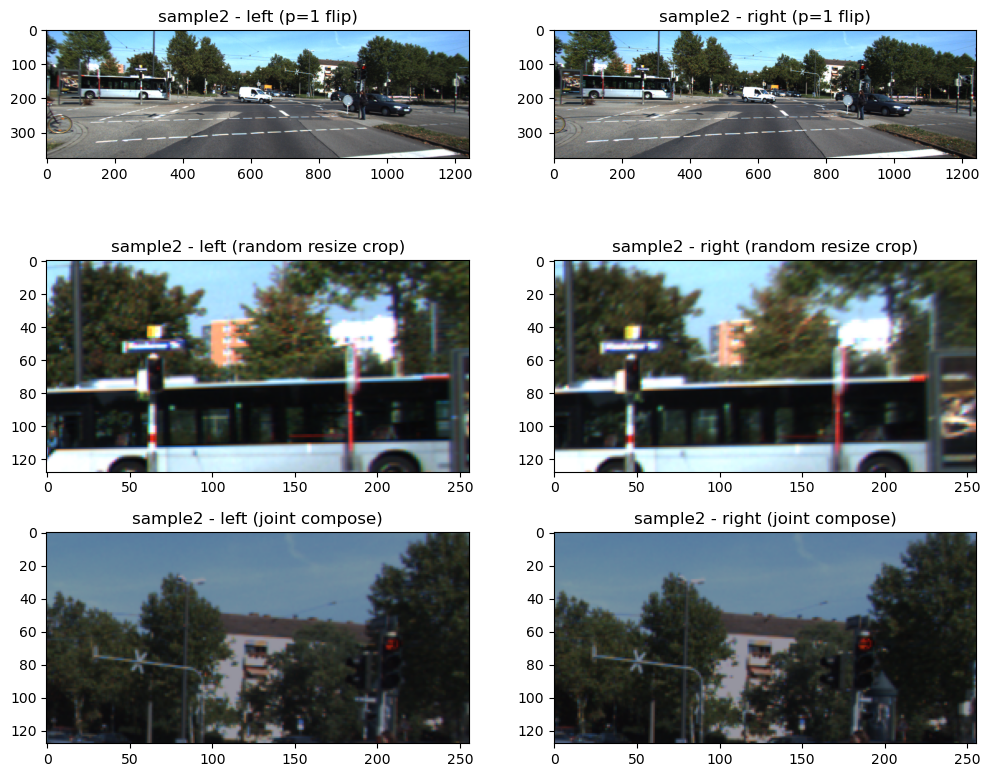

In [143]:
base = Kitti2015Stereo(
    DATASET_PATH, 
    split = 'train',
)[15]
flipped = Kitti2015Stereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([RandomFlip(p=1)]),
)[15]
resized = Kitti2015Stereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([RandomResizeCrop(0.75, 1.25, 128, 256)]),
)[15]
joint = Kitti2015Stereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([RandomFlip(p=1), RandomColorAugment(), RandomResizeCrop(0.75, 1.25, 128, 256)]),
)[15]

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(3,2,1)
plt.title('sample2 - left (p=1 flip)')
ax1.imshow(flipped[0])
ax1 = fig.add_subplot(3,2,2)
plt.title('sample2 - right (p=1 flip)')
ax1.imshow(flipped[1])
ax1 = fig.add_subplot(3,2,3)
plt.title('sample2 - left (random resize crop)')
ax1.imshow(resized[0])
ax1 = fig.add_subplot(3,2,4)
plt.title('sample2 - right (random resize crop)')
ax1.imshow(resized[1])
ax1 = fig.add_subplot(3,2,5)
plt.title('sample2 - left (joint compose)')
ax1.imshow(joint[0])
ax1 = fig.add_subplot(3,2,6)
plt.title('sample2 - right (joint compose)')
ax1.imshow(joint[1])

We will have 4 seperate data loaders. The first 3 will use the KITTI 2015 stereo as a sanity test, and the last will use a dataset that features ground truth disparity maps. 

In [144]:
class KittiStereo(Dataset):
    def __init__(self, *args, **kwargs):
        self.split = kwargs['split']
        self.base_dataset = Kitti2015Stereo(*args, **kwargs)

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        data = self.base_dataset[idx]
        return data[:2]  # Only return the first two items (left & right images)

In [213]:
sanity_data =Subset(KittiStereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([CropToMultiple(128), ToTensor()]),
), indices=[6])

train_data = KittiStereo(
    DATASET_PATH, 
    split = 'train', 
    transforms = JointCompose([CropToMultiple(128), RandomColorAugment(), RandomFlip(), ToTensor()]),
)

val_data = KittiStereo(
    DATASET_PATH, 
    split='test',
    transforms = JointCompose([CropToMultiple(128), ToTensor()])
)

TRAIN_BATCH_SIZE = 4

sanity_loader = DataLoader(sanity_data, batch_size=1,shuffle=False)
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)

## Model

We will use the fully convolutional network described by the paper referenced in the slides. The model devides into an encoder and decoder. At a high level, the encoder recognizes featueres and the decoder reconstructs a disparity map given these identified features. The decoder uses *transposed convolutions* to learn how to upsample at each step, instead of just upsampling via bilinear interpolation, for example.

In [ ]:
### model
class Model(nn.Module):
    def __init__(self, use_conv_transpose = False):
        super().__init__()

        #scalar
        self.scale = nn.Parameter(torch.tensor(0.3))

        # Miscelaneous functions
        self.act_fn = nn.ELU(inplace=True)
        self.disp_act_fn = nn.ReLU()
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')

        # Encoder
        self.conv1  = nn.Conv2d(3  , 32 , kernel_size=7, stride=2, padding=3)
        self.conv1b = nn.Conv2d(32 , 32 , kernel_size=7, stride=1, padding=3)

        self.conv2  = nn.Conv2d(32 , 64 , kernel_size=5, stride=2, padding=2)
        self.conv2b = nn.Conv2d(64 , 64 , kernel_size=5, stride=1, padding=2)

        self.conv3  = nn.Conv2d(64 , 128, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv4  = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4b = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv5  = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)


        self.conv6  = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.conv6b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        
        self.conv7  = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.conv7b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.upconv7 = nn.Sequential(
                       nn.Upsample(scale_factor=2, mode='bilinear'),
                       nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        )
        self.iconv7  = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)

        self.upconv6 = nn.Sequential(
                       nn.Upsample(scale_factor=2, mode='bilinear'),
                       nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        )
        self.iconv6  = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)

        self.upconv5 = nn.Sequential(
                       nn.Upsample(scale_factor=2, mode='bilinear'),
                       nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        )
        self.iconv5  = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)

        self.upconv4 = nn.Sequential(
                       nn.Upsample(scale_factor=2, mode='bilinear'),
                       nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        )
        self.iconv4  = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.disp4   = nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=1)

        self.upconv3 = nn.Sequential(
                       nn.Upsample(scale_factor=2, mode='bilinear'),
                       nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        )
        self.iconv3  = nn.Conv2d(128 + 2, 64, kernel_size=3, stride=1, padding=1)
        self.disp3   = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1)

        self.upconv2 = nn.Sequential(
                       nn.Upsample(scale_factor=2, mode='bilinear'),
                       nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        )
        self.iconv2  = nn.Conv2d(64 + 2, 32, kernel_size=3, stride=1, padding=1)
        self.disp2   = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)

        self.upconv1 = nn.Sequential(
                       nn.Upsample(scale_factor=2, mode='bilinear'),
                       nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        )
        self.iconv1  = nn.Conv2d(16 + 2, 16, kernel_size=3, stride=1, padding=1)
        self.disp1   = nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1)

        if use_conv_transpose:
            self.upconv7 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.upconv6 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)


    def forward(self, left_image):
        # Encoder
        conv1  = self.act_fn(self.conv1(left_image))
        conv1b = self.act_fn(self.conv1b(conv1))
        conv2  = self.act_fn(self.conv2(conv1b))
        conv2b = self.act_fn(self.conv2b(conv2))
        conv3  = self.act_fn(self.conv3(conv2b))
        conv3b = self.act_fn(self.conv3b(conv3))
        conv4  = self.act_fn(self.conv4(conv3b))
        conv4b = self.act_fn(self.conv4b(conv4))
        conv5  = self.act_fn(self.conv5(conv4b))
        conv5b = self.act_fn(self.conv5b(conv5))
        conv6  = self.act_fn(self.conv6(conv5b))
        conv6b = self.act_fn(self.conv6b(conv6))
        conv7  = self.act_fn(self.conv7(conv6b))
        conv7b = self.act_fn(self.conv7b(conv7))

        # Decoder
        upconv7 = self.act_fn(self.upconv7(conv7b))
        iconv7  = self.act_fn(self.iconv7(torch.cat([upconv7, conv6b], dim=1)))
        upconv6 = self.act_fn(self.upconv6(iconv7))
        iconv6  = self.act_fn(self.iconv6(torch.cat([upconv6, conv5b], dim=1)))
        upconv5 = self.act_fn(self.upconv5(iconv6))
        iconv5  = self.act_fn(self.iconv5(torch.cat([upconv5, conv4b], dim=1)))  
        upconv4 = self.act_fn(self.upconv4(iconv5)) 
        iconv4  = self.act_fn(self.iconv4(torch.cat([upconv4, conv3b], dim=1)))  
        disp4   = self.scale * self.disp_act_fn(self.disp4(iconv4))
        upconv3 = self.act_fn(self.upconv3(iconv4))
        iconv3  = self.act_fn(self.iconv3(torch.cat([upconv3, conv2b, self.upsample2(disp4)], dim=1)))
        disp3   = self.scale * self.disp_act_fn(self.disp3(iconv3))
        upconv2 = self.act_fn(self.upconv2(iconv3))
        iconv2  = self.act_fn(self.iconv2(torch.cat([upconv2, conv1b, self.upsample2(disp3)], dim=1))) 
        disp2   = self.scale * self.disp_act_fn(self.disp2(iconv2))  
        upconv1 = self.act_fn(self.upconv1(iconv2))
        iconv1  = self.act_fn(self.iconv1(torch.cat([upconv1, self.upsample2(disp2)], dim=1)))
        disp1 = self.scale * self.disp_act_fn(self.disp1(iconv1))

        return disp1

## Reconstructing the image from the disparity

In [174]:
import torch
import torch.nn.functional as F

def bilinear_sampler_1d_h(img, x_offset, wrap_mode='border'):
    """
    img:         Tensor of shape [B, C, H, W] (PyTorch uses channel-first).
    x_offset:    Disparity tensor of shape [B, 1, H, W] with values in [-1, 1].
                 These are normalized horizontal offsets.
    wrap_mode:   Either 'border' (which pads the image at the borders) or 'edge'.
                 (Here we treat both as using grid_sample's 'border' option.)
    """
    
    # Get shape; note that TensorFlow's version uses [B, H, W, C],
    # but here we assume [B, C, H, W].
    B, C, H, W = img.size()
    device = img.device

    # Ensure x_offset is [B, H, W] by squeezing the channel dim if needed.
    if x_offset.dim() == 4 and x_offset.size(1) == 1:
        x_offset = x_offset.squeeze(1)  # now shape [B, H, W]
    
    # Create meshgrid in pixel coordinates.
    # In TF, the meshgrid goes from 0 to width-1 and 0 to height-1.
    # We use torch.arange and torch.meshgrid to build similar grids.
    # We set indexing='ij' so that the first output corresponds to rows (y) and the second to columns (x).
    y_grid, x_grid = torch.meshgrid(
        torch.arange(H, device=device).float(),
        torch.arange(W, device=device).float(),
        indexing='ij'
    )  # both of shape [H, W]
    
    # Expand to batch size.
    # x_grid and y_grid become [B, H, W] (each identical across the batch).
    x_grid = x_grid.unsqueeze(0).expand(B, H, W)
    y_grid = y_grid.unsqueeze(0).expand(B, H, W)

    # Scale the normalized x_offset into pixel units.
    # (In the TF code: x_offset_scaled = reshape(x_offset)*width)
    x_offset_scaled = x_offset * W
    
    # Add the offset to the original x coordinates. This mirrors:
    #     x_t_flat += x_offset_scaled 
    # in the TF function.
    x_new = x_grid + x_offset_scaled

    # Now we have new pixel coordinates (x_new, y_grid).
    # Next, convert these pixel coordinates to normalized coordinates for grid_sample.
    # The conversion is: normalized_x = (2*x_pixel/(W - 1)) - 1, similar for y.
    x_norm = 2 * x_new / (W - 1) - 1
    y_norm = 2 * y_grid / (H - 1) - 1

    # Construct the sampling grid. grid_sample expects a grid of shape [B, H, W, 2],
    # with the last dimension giving (x, y) in normalized coordinates.
    # Notice that we stack x_norm and y_norm so that at each location the offset is applied only on x.
    grid = torch.stack((x_norm, y_norm), dim=3)  # shape: [B, H, W, 2]

    # For wrap_mode, grid_sample provides several options:
    # - padding_mode='border' returns the border value for out-of-bound coordinates.
    # We choose 'border' to match the TF pad+clip behavior.
    pad_mode = 'border' if wrap_mode == 'border' else 'border'  # (You may adjust if you want 'edge')

    # Use grid_sample to perform bilinear interpolation.
    # Note: align_corners=True makes the normalized coordinates correspond exactly to pixel centers.
    output = F.grid_sample(img, grid, mode='bilinear', padding_mode=pad_mode, align_corners=True)
    
    return output


In [175]:
import torch
import torch.nn.functional as F


## leftIm defines if we are reconstructing the left image or the right image
def reconStruct(im, disp, leftIm):
    if(leftIm):
        return bilinear_sampler_1d_h(im ,-1*disp)
    else:
        return bilinear_sampler_1d_h(im, disp)


Example on a ground truth image

tensor(0.0365) tensor(0.) tensor(0.0176)
torch.Size([3, 288, 384])
torch.Size([3, 288, 384])


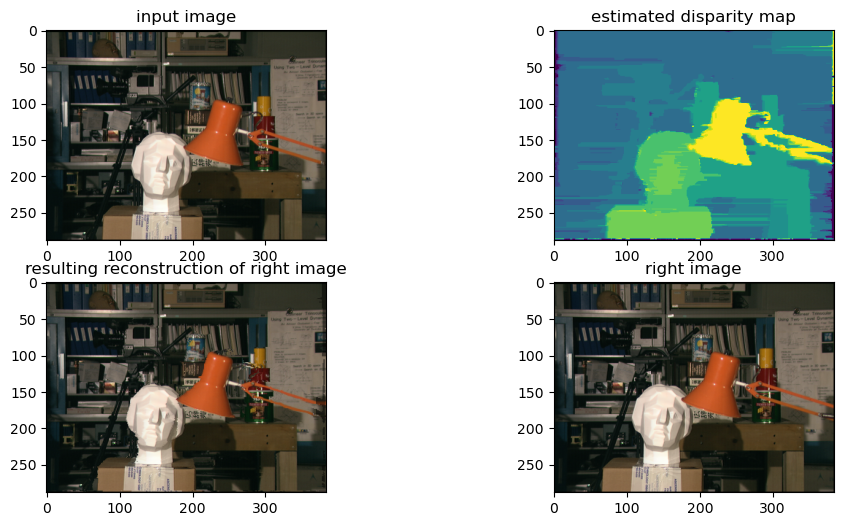

In [176]:
imL = Image.open("images/tsukuba/scene1.row3.col3.ppm")
# imL = Image.open("Backpack-perfect/im0.png")
gt = Image.open("images/tsukuba/truedisp.row3.col3.pgm")
# gt = Image.open("Backpack-perfect/disp0.pfm")
gt = np.load("images/tsukuba/resMap.pgm").astype(np.float32)
# gt = np.astype(gt, np.float32)
gt = tF.to_tensor(gt)
# print(gt.shape)
gt = gt/gt.shape[2]
print(torch.max(gt), torch.min(gt), torch.mean(gt))

tensIml = tF.to_tensor(imL)[None]

# gt[gt==float("inf")] = 0
# gt = gt
# gt = tF.to_pil_image(gt)

imR = Image.open("images/tsukuba/scene1.row3.col4.ppm")
# imR = Image.open("Backpack-perfect/im1.png")

# print(np.max(gt))
# print(torch.unique(tF.to_tensor(gt)))
# print()

print(tF.to_tensor(imL).shape)
# print(tF.to_tensor(gt).shape)
# print(generate_image_right(tF.to_tensor(im)[None], tF.to_tensor(gt)[None]).shape)
# regen_im = generate_image_right(tF.to_tensor(imL)[None], tF.to_tensor(gt)[None])[0]
regen_im = reconStruct(tensIml, gt[None], False)[0]
# regen_im = reconStruct(*convert_torch_to_tf(tensIml, gt[None]), False)[0]
gt = gt.permute(1, 2, 0)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("input image")
ax1.imshow(imL)
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("estimated disparity map")
ax2.imshow(gt)
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("resulting reconstruction of right image")
print(regen_im.shape)
ax3.imshow(regen_im.permute(1, 2, 0))
# ax3.imshow(regen_im)
ax3 = fig.add_subplot(2, 2, 4)
ax3.set_title("right image")
ax3.imshow(imR)




## Loss Function

source of loss function:
from paper

Difficulties with loss function:
- keeping the loss function only with tensor operations to keep the .backward() functionality valid

In [177]:
a, b = torch.tensor([1, 2, 3]), torch.tensor([1, 2, 3])
print(a, b, a*b)
# print(torch.square(a).sum(dim=1))

tensor([1, 2, 3]) tensor([1, 2, 3]) tensor([1, 4, 9])


In [178]:
# maybe add later
def weight_term(im1, im2, d1, d2, sig):
    w = torch.exp(-1*torch.square(im1 - im2).sum(dim=1)/(2*sig*sig))
    return (torch.abs(d1 - d2)* w).sum()
def disparity_image_loss(im, disp, sig = 2):
    """
    im: [B, 3, H, W] image
    disp: [B, 1, H, W] image
    """
    imgd = torch.roll(im, -1, dims=2)
    imgr = torch.roll(im, -1, dims=3)
    imgdiag = torch.roll(imgr, -1, dims=2)

    dispd = torch.roll(disp, -1, dims=2)
    dispr = torch.roll(disp, -1, dims=3)
    dispdiag = torch.roll(dispr, -1, dims=2)

    return weight_term(im, imgd, disp, dispd, sig) + weight_term(im, imgr, disp, dispr, sig) + weight_term(im, imgdiag, disp, dispdiag, sig)

# def disparity_uniform_loss(values):
#     mean_loss = (values.mean() - 0.5).pow(2)
#     var_loss = (values.var(unbiased=False) - (1/12)).pow(2)
#     return mean_loss + var_loss

def disparity_uniform_loss(values, lmbda = 10, lmbda2 = 10):

    # return torch.exp(lmbda*(torch.min(values) - torch.max(values))) + torch.exp((1/12) - values.var() )
    # print(torch.min(values) - torch.max(values), values.var())
    # return torch.exp(lmbda*(torch.min(values) - torch.max(values))) + torch.exp(lmbda2 * -1 * values.var())
    return torch.exp(lmbda2 * -1 * values.var())
    

In [179]:


def ssim(img1, img2):
    """Simplified SSIM using a 3x3 filter."""
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, 3, 1, 1)
    mu2 = F.avg_pool2d(img2, 3, 1, 1)

    sigma1 = F.avg_pool2d(img1 * img1, 3, 1, 1) - mu1 ** 2
    sigma2 = F.avg_pool2d(img2 * img2, 3, 1, 1) - mu2 ** 2
    sigma12 = F.avg_pool2d(img1 * img2, 3, 1, 1) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 + sigma2 + C2))
    return torch.clamp((1 - ssim_map) / 2, 0, 1)
    # return ssim_map

def gradient_x(img):
    return img[:, :, :, :-1] - img[:, :, :, 1:]

def gradient_y(img):
    return img[:, :, :-1, :] - img[:, :, 1:, :]


def appearance_loss(img, recon, alpha):
    l1 = torch.abs(img - recon)
    ssim_loss = ssim(img, recon) #(1 - SSIM)/2 built in already
    return (alpha * ssim_loss.mean()) + (1-alpha)*l1.mean()
    return (alpha * (1 - ssim_loss.mean()) / 2) + ((1 - alpha) * l1.mean())

# def appearance_loss(img, recon, alpha):
#     return torch.square(img - recon).sum()/(img.shape[2]*img.shape[3])

def disparity_smoothness(disp, img, x=1, y=2):
    disp_grad_x = gradient_x(disp)
    disp_grad_x[torch.isinf(disp_grad_x)] = 0
    disp_grad_x[torch.isnan(disp_grad_x)] = 0
    disp_grad_y = gradient_y(disp)
    disp_grad_y[torch.isinf(disp_grad_y)] = 0
    disp_grad_y[torch.isnan(disp_grad_y)] = 0
    img_grad_x = gradient_x(img)
    img_grad_y = gradient_y(img)

    # print(img_grad_x.shape)
    
    weights_x = torch.exp(-torch.sum(torch.abs(img_grad_x), 1, keepdim=True))
    weights_y = torch.exp(-torch.sum(torch.abs(img_grad_y), 1, keepdim=True))

    smoothness_x = x*torch.abs(disp_grad_x * weights_x)
    smoothness_y = y*disp_grad_y * weights_y
    # print(torch.isnan(smoothness_x).any())
    return smoothness_x.abs().mean() + smoothness_y.abs().mean()



def lr_consistency_loss(disp_left, disp_right):
    """
    Args:
        disp_left:  [B, 1, H, W] disparity map from left view (predicts right image)
        disp_right: [B, 1, H, W] disparity map from right view (predicts left image)

    Returns:
        Scalar tensor representing left-right consistency loss.
    """

    # if it comes in as [1, H, W] instead
    # disp_left, disp_right = disp_left[None], disp_right[None]

    B, _, H, W = disp_left.shape

    # Create normalized horizontal coordinate grid
    grid_x = torch.linspace(-1.0, 1.0, W).view(1, 1, 1, W).expand(B, 1, H, W).to(disp_left.device)
    grid_y = torch.linspace(-1.0, 1.0, H).view(1, 1, H, 1).expand(B, 1, H, W).to(disp_left.device)

    # Normalize disparity to [-1, 1] range
    # disp_left_norm = disp_left / ((W - 1) / 2)
    # disp_right_norm = disp_right / ((W - 1) / 2)
    disp_left_norm = disp_left 
    disp_right_norm = disp_right 

    # Sample right disparity using left disparity to warp
    grid_warped_right = torch.cat([grid_x - disp_left_norm, grid_y], dim=1)
    grid_warped_right = grid_warped_right.permute(0, 2, 3, 1)  # [B, H, W, 2]
    sampled_right = F.grid_sample(disp_right, grid_warped_right, mode='bilinear', padding_mode='border', align_corners=True)

    # Sample left disparity using right disparity to warp
    grid_warped_left = torch.cat([grid_x + disp_right_norm, grid_y], dim=1)
    grid_warped_left = grid_warped_left.permute(0, 2, 3, 1)
    sampled_left = F.grid_sample(disp_left, grid_warped_left, mode='bilinear', padding_mode='border', align_corners=True)

    # L1 loss between disparity and its warped counterpart
    # print(torch.isinf(disp_left).any())
    loss_left = torch.abs(disp_left - sampled_right).mean()
    loss_right = torch.abs(disp_right - sampled_left).mean()

    return loss_left + loss_right

def test_loss(imL, imR, dL, dR, reconImL, reconImR):
    loss = nn.MSELoss()
    return loss(imR, reconImR) + loss(imL, reconImL)
    # return loss(imR, reconImR)

def custom_loss(imL, imR, dL, dR, recImL, recImR, alpha=0.85, alpha_ap=5.0, alpha_ds=1e-4, alpha_lr=1, alpha_di = 0, alpha_uni = 5e-5, debug = False):
    # config 
    # alpha, alpha_ap, alpha_ds, alpha_lr, alpha_di, alpha_uni = ()

    # loss_ap = appearance_loss(imL, recImL, alpha) + appearance_loss(imR, recImR, alpha)
    loss_ap = test_loss(imL, imR, dL, dR, recImL, recImR)
    if debug: print("loss_ap", loss_ap)

    loss_ds = disparity_smoothness(dL, imR) + disparity_smoothness(dR, imL)
    # loss_ds = 0
    if debug: print("loss_ds", loss_ds)

    loss_lr = lr_consistency_loss(dL, dR)
    if(torch.isnan(loss_lr)):
        # penalty to discourage infinite disparity
        loss_lr = 1000000000000
    # --- Total Loss ---
    
    loss_di = disparity_image_loss(imL, dL) + disparity_image_loss(imR, dR)
    # loss_di = 0

    loss_uni = disparity_uniform_loss(dL) + disparity_uniform_loss(dR)
    # loss_uni = 0

    if debug: print("loss_lr", loss_lr)
    total_loss = alpha_ap * loss_ap + alpha_ds * loss_ds + alpha_lr * loss_lr + alpha_di * loss_di + alpha_uni*loss_uni
    # total_loss = alpha_ap * loss_ap  + alpha_ds*loss_ds + alpha_lr * loss_lr
    return total_loss



Testing the loss function

In [180]:
imL =tF.to_tensor(Image.open("images/tsukuba/scene1.row3.col3.ppm"))[None]
imR =tF.to_tensor(Image.open("images/tsukuba/scene1.row3.col4.ppm"))[None]
dL = tF.to_tensor(Image.open("images/tsukuba/truedisp.row3.col3.pgm"))[None]
width = imL.shape[2]
dL /= width
dR = -1 * dL

poop = torch.zeros(dL.shape)

print("Good loss: ", custom_loss(imL, imR, dL, dR, reconStruct(imR, dR, True), reconStruct(imL, dL, False), debug=True))
print("Bad loss: ", custom_loss(imL, imR, poop, poop, reconStruct(imR, poop, True), reconStruct(imL, poop, False), debug=True))
print(disparity_image_loss(imL, dL), disparity_image_loss(imR, dR), disparity_image_loss(imL, poop))
print(disparity_uniform_loss(poop, lmbda2=10000), disparity_uniform_loss(dL, lmbda2=1e7), torch.min(dL), torch.max(dL), dL.mean(), dL.var())


loss_ap tensor(0.0411)
loss_ds tensor(0.0001)
loss_lr tensor(0.0047)
Good loss:  tensor(0.2105)
loss_ap tensor(0.0427)
loss_ds tensor(0.)
loss_lr tensor(0.)
Bad loss:  tensor(0.2137)
tensor(8.0964) tensor(8.1258) tensor(0.)
tensor(1.) tensor(0.0019) tensor(0.) tensor(0.0031) tensor(0.0012) tensor(6.2768e-07)


## Validation

In [233]:
strucutral_sim = StructuralSimilarityIndexMeasure(data_range=255)

def validate(val_loader, net):

    net.eval()
    val_loss = 0

    net = net.cuda()
    strucutral_sim_cuda = strucutral_sim.cuda()
    with torch.no_grad():
        for i, data in enumerate(val_loader):

            imL, imR = data
            imL, imR = imL.cuda(), imR.cuda()

            dL = net.forward(imL)[0, 0]

            recon_imR = reconStruct(imL, dL[None], False)[0].permute(1, 2, 0)

            val_loss += strucutral_sim_cuda(recon_imR.permute(2, 0, 1)[None], imR)

    
    return val_loss/len(val_loader.dataset)


## Trainer


In [ ]:
def train(train_loader, net, optimizer, loss_graph, loss_function):

    net.train()
    # if USE_GPU:
    net = net.cuda()
    val_loss = 0
    for i, data in enumerate(train_loader):

        imL, imR = data
        # if USE_GPU:
        imL, imR = imL.cuda(), imR.cuda()

        optimizer.zero_grad()
        output = net.forward(imL)
        dL, dR = output[:, torch.newaxis,  0], output[:, torch.newaxis, 1]
        
        # reconL = reconStruct(*convert_torch_to_tf(imR, dR), True)
        # reconR = reconStruct(*convert_torch_to_tf(imL, dL), False)

        main_loss = loss_function(imL, imR, dL, dR, reconStruct(imR, dR, True), reconStruct(imL, dL, False))
        loss = main_loss.item()
        val_loss += loss
        loss_graph.append(loss)
        main_loss.backward()
        optimizer.step()
        # loss_graph.append() Populate this list to graph the loss

    # Return the value of loss (averaged over the loaded data)
    return val_loss/len(train_loader)

In [183]:
def train_net(loader, net, optimizer, EPOCH, loss_function = custom_loss):
    net.train()

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)

    for e in range(EPOCH):
        loss = train(loader, net, optimizer, loss_graph, loss_function)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for OVERFIT_NET')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

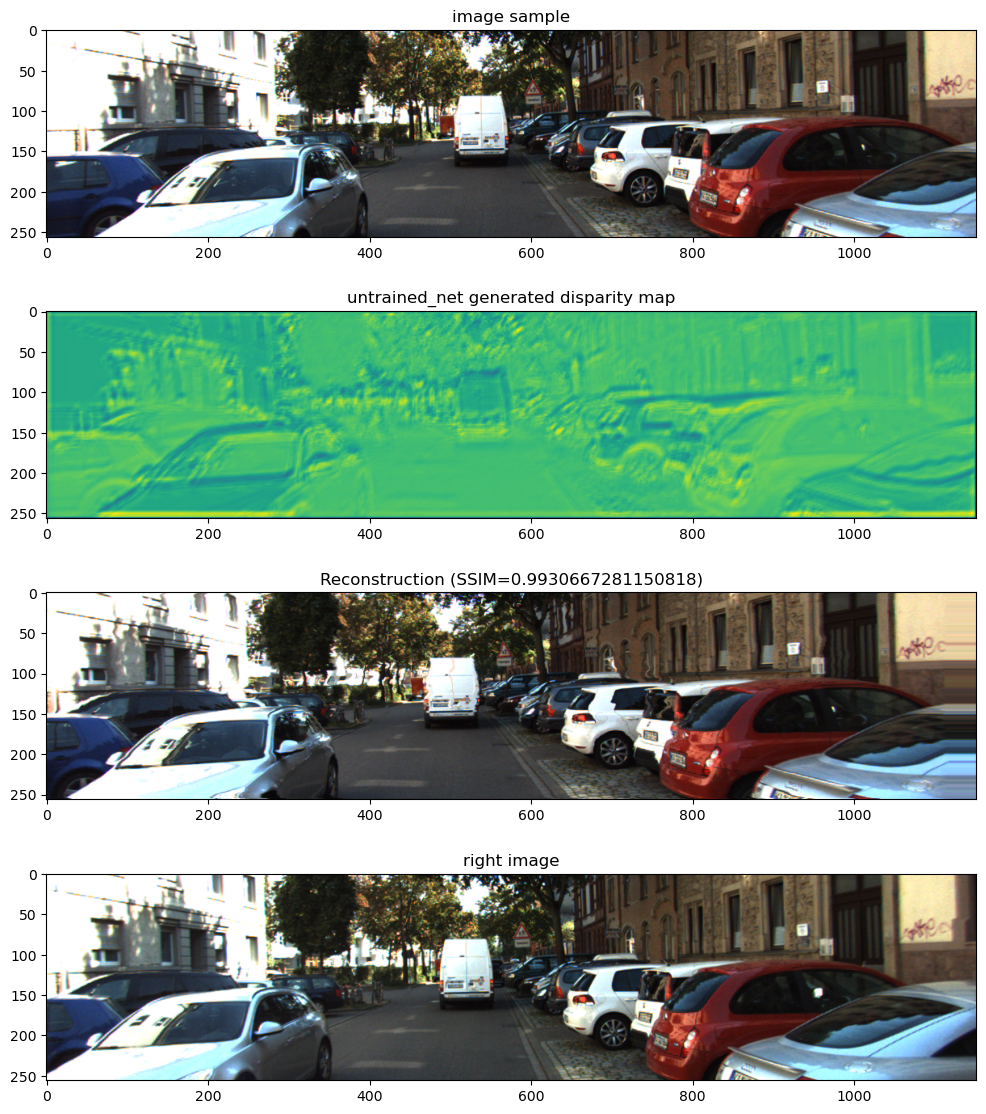

In [209]:
untrained_net = Model().eval()

untrained_net.cuda()

im1, imR = KittiStereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([CropToMultiple(128), ToTensor()]),
)[6]

im1 = im1.cuda()

dL1 = untrained_net.forward(im1[None])[0, 0]
recon = reconStruct(im1[None].cpu().detach(), dL1[None].cpu().detach(), False)[0].permute(1, 2, 0)
val = strucutral_sim(imR[None], recon.permute(2, 0, 1)[None])

fig = plt.figure(figsize=(12,14))
ax = fig.add_subplot(4,1,1)
plt.title('image sample')
ax.imshow(im1.cpu().permute(1, 2, 0).numpy())
ax = fig.add_subplot(4,1,2)
plt.title("untrained_net generated disparity map")
ax.imshow(dL1.cpu().detach().numpy())
ax = fig.add_subplot(4, 1, 3)
plt.title(f"Reconstruction (SSIM={val})")
ax.imshow(recon)
ax = fig.add_subplot(4, 1, 4)
plt.title("right image")
ax.imshow(imR.permute(1, 2, 0))

torch.save(untrained_net.state_dict(), "untrained_net.pth")

## Overfit model
First, we are going to train an overfit net to a single image to get a sanity check that the error function and model are working as intended

We use the same 

In [185]:
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8)
    return optimizer

Starting Training...
Epoch: 0 Loss: 0.8465409278869629
Epoch: 1 Loss: 0.8772482872009277
Epoch: 2 Loss: 0.8556779623031616
Epoch: 3 Loss: 0.8424772620201111
Epoch: 4 Loss: 0.8499745726585388
Epoch: 5 Loss: 0.8503311276435852
Epoch: 6 Loss: 0.8446145057678223
Epoch: 7 Loss: 0.8398459553718567
Epoch: 8 Loss: 0.8434277772903442
Epoch: 9 Loss: 0.8454508185386658
Epoch: 10 Loss: 0.8432915210723877
Epoch: 11 Loss: 0.8387938141822815
Epoch: 12 Loss: 0.8397058844566345
Epoch: 13 Loss: 0.8365059494972229
Epoch: 14 Loss: 0.8310906887054443
Epoch: 15 Loss: 0.8320856094360352
Epoch: 16 Loss: 0.8213430047035217
Epoch: 17 Loss: 0.8107607364654541
Epoch: 18 Loss: 0.7935040593147278
Epoch: 19 Loss: 0.7727988958358765
Epoch: 20 Loss: 0.8131063580513
Epoch: 21 Loss: 0.7794639468193054
Epoch: 22 Loss: 0.767443060874939
Epoch: 23 Loss: 0.7894364595413208
Epoch: 24 Loss: 0.7798471450805664
Epoch: 25 Loss: 0.7665137052536011
Epoch: 26 Loss: 0.7671229243278503
Epoch: 27 Loss: 0.7634128928184509
Epoch: 28 Los

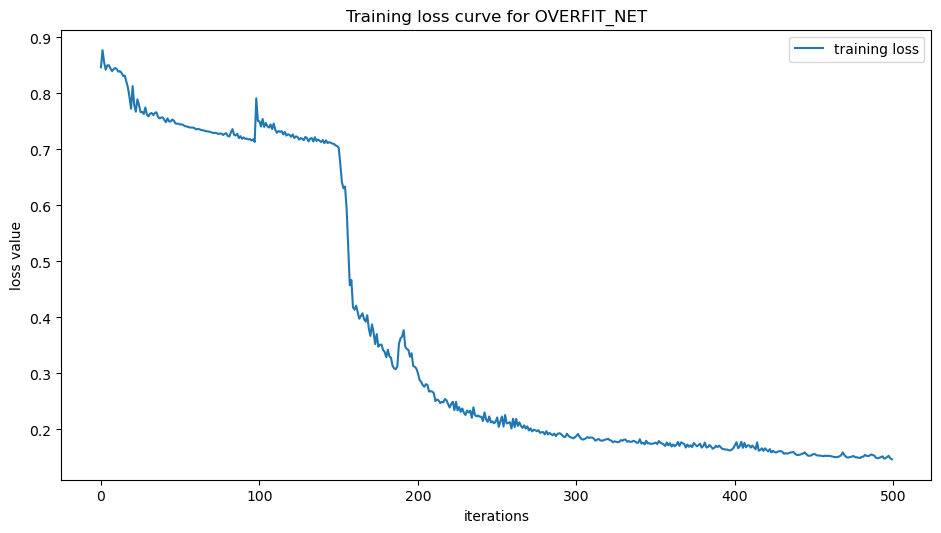

In [187]:
%%time

overfit_net = copy.deepcopy(untrained_net)

EPOCH = 500

optimizer = get_optimizer(overfit_net)

train_net(sanity_loader, overfit_net, optimizer, EPOCH)

torch.save(overfit_net.state_dict(), "overfit_net.pth")

Now we run it on its own image and a random image in the set to compare its results

torch.Size([256, 1152])


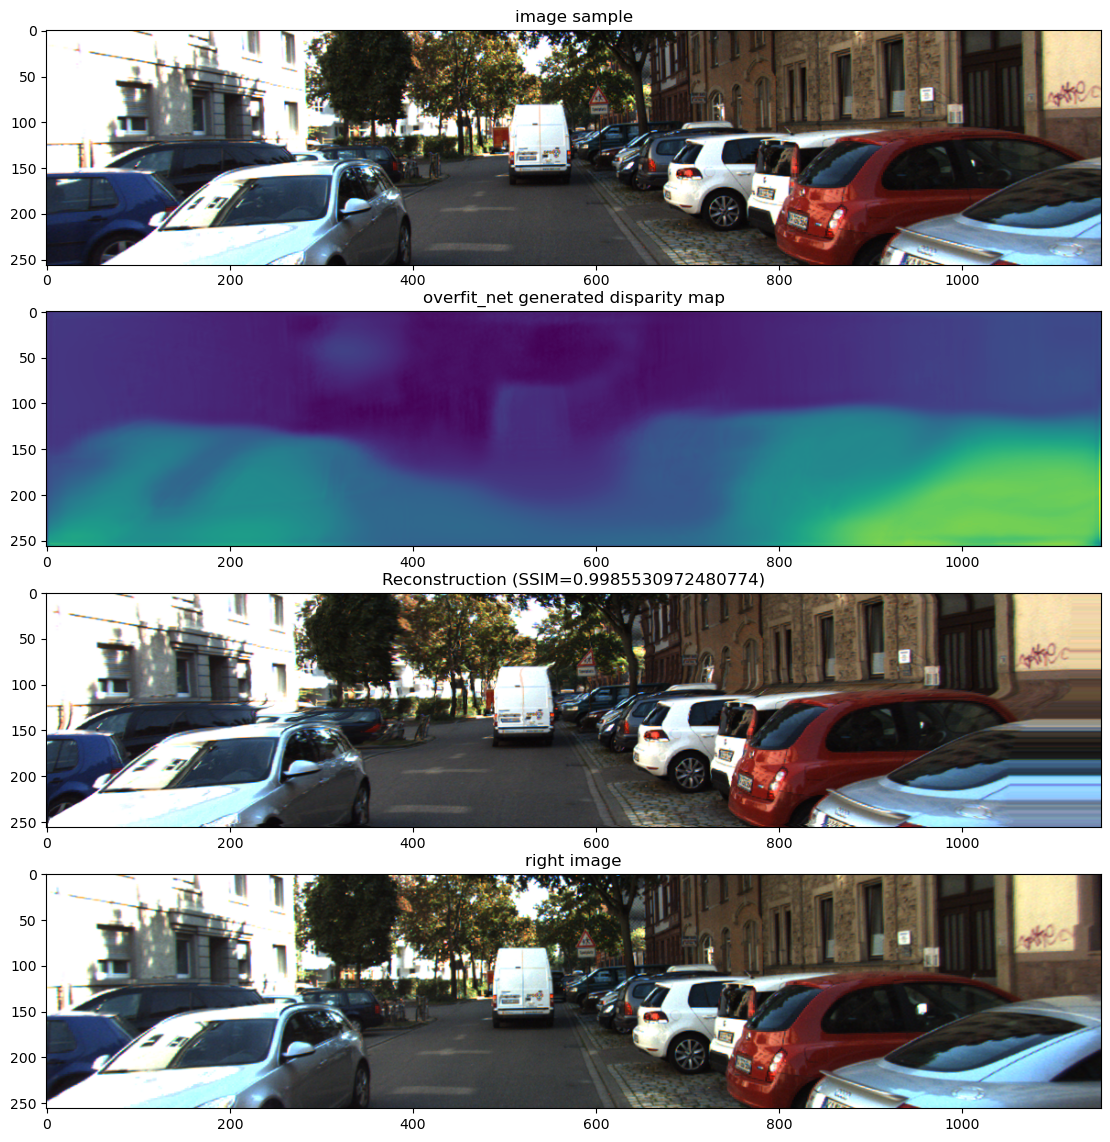

In [ ]:
overfit_net.eval()

im1, imR = KittiStereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([CropToMultiple(128), ToTensor()]),
)[6]

im1 = im1.cuda()

dL1 = overfit_net.forward(im1[None])[0, 0]
recon = reconStruct(im1[None].cpu().detach(), dL1[None].cpu().detach(), False)[0].permute(1, 2, 0)
val = strucutral_sim(imR[None], recon.permute(2, 0, 1)[None])

fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(4,1,1)
plt.title('image sample')
ax.imshow(im1.cpu().permute(1, 2, 0).numpy())
ax = fig.add_subplot(4,1,2)
plt.title("overfit_net generated disparity map")
ax.imshow(dL1.cpu().detach().numpy())
ax = fig.add_subplot(4, 1, 3)
plt.title(f"Reconstruction (SSIM={val})")
ax.imshow(recon)
ax = fig.add_subplot(4, 1, 4)
plt.title("right image")
ax.imshow(imR.permute(1, 2, 0))



## Trained Model

Starting Training...
Epoch: 0 Loss: 0.3318557250499725
Epoch: 1 Loss: 0.2596359691023827
Epoch: 2 Loss: 0.224910686314106
Epoch: 3 Loss: 0.23135873824357986
Epoch: 4 Loss: 0.22330162048339844
Epoch: 5 Loss: 0.22408575281500817
Epoch: 6 Loss: 0.22662835836410522
Epoch: 7 Loss: 0.24345004692673683
Epoch: 8 Loss: 0.23366835385560988
Epoch: 9 Loss: 0.21404754102230072
Epoch: 10 Loss: 0.22745940297842027
Epoch: 11 Loss: 0.2166339500248432
Epoch: 12 Loss: 0.2156759035587311
Epoch: 13 Loss: 0.21941291868686677
Epoch: 14 Loss: 0.21923300489783287
Epoch: 15 Loss: 0.2124096728861332
Epoch: 16 Loss: 0.21742402523756027
Epoch: 17 Loss: 0.21719470858573914
Epoch: 18 Loss: 0.2176937121152878
Epoch: 19 Loss: 0.20838274896144868
Epoch: 20 Loss: 0.20641906797885895
Epoch: 21 Loss: 0.20104428857564927
Epoch: 22 Loss: 0.2026345780491829
Epoch: 23 Loss: 0.21438429549336432
Epoch: 24 Loss: 0.21192481145262718
Epoch: 25 Loss: 0.21471898436546324
Epoch: 26 Loss: 0.19906015947461128
Epoch: 27 Loss: 0.20008781

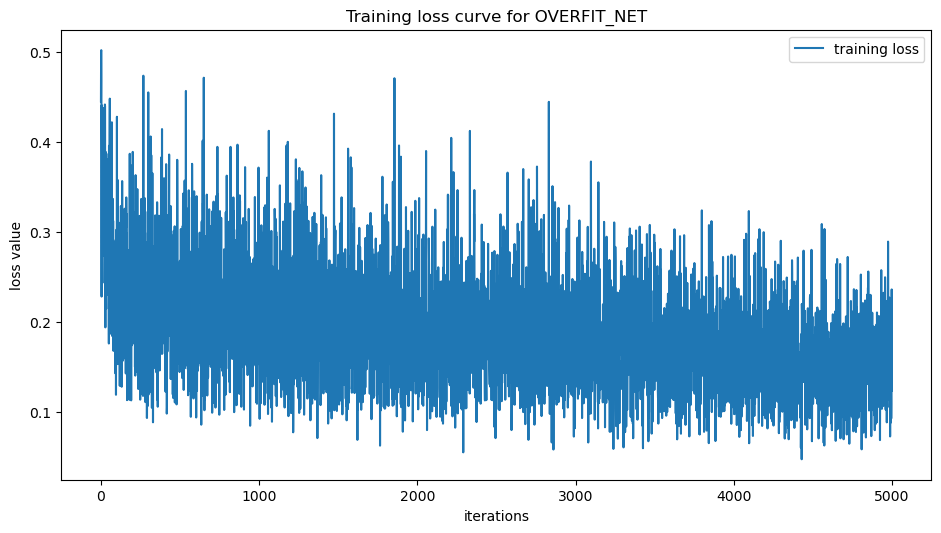

In [243]:
%%time

trained_net = copy.deepcopy(untrained_net)

EPOCH = 100

optimizer = get_optimizer(trained_net)

# train_net(train_loader, trained_net, optimizer, EPOCH, test_loss)
train_net(train_loader, trained_net, optimizer, EPOCH)

torch.save(trained_net.state_dict(), "trained_net.pth")

Similarly, we compare visually the results compared to the overfit image and another random image

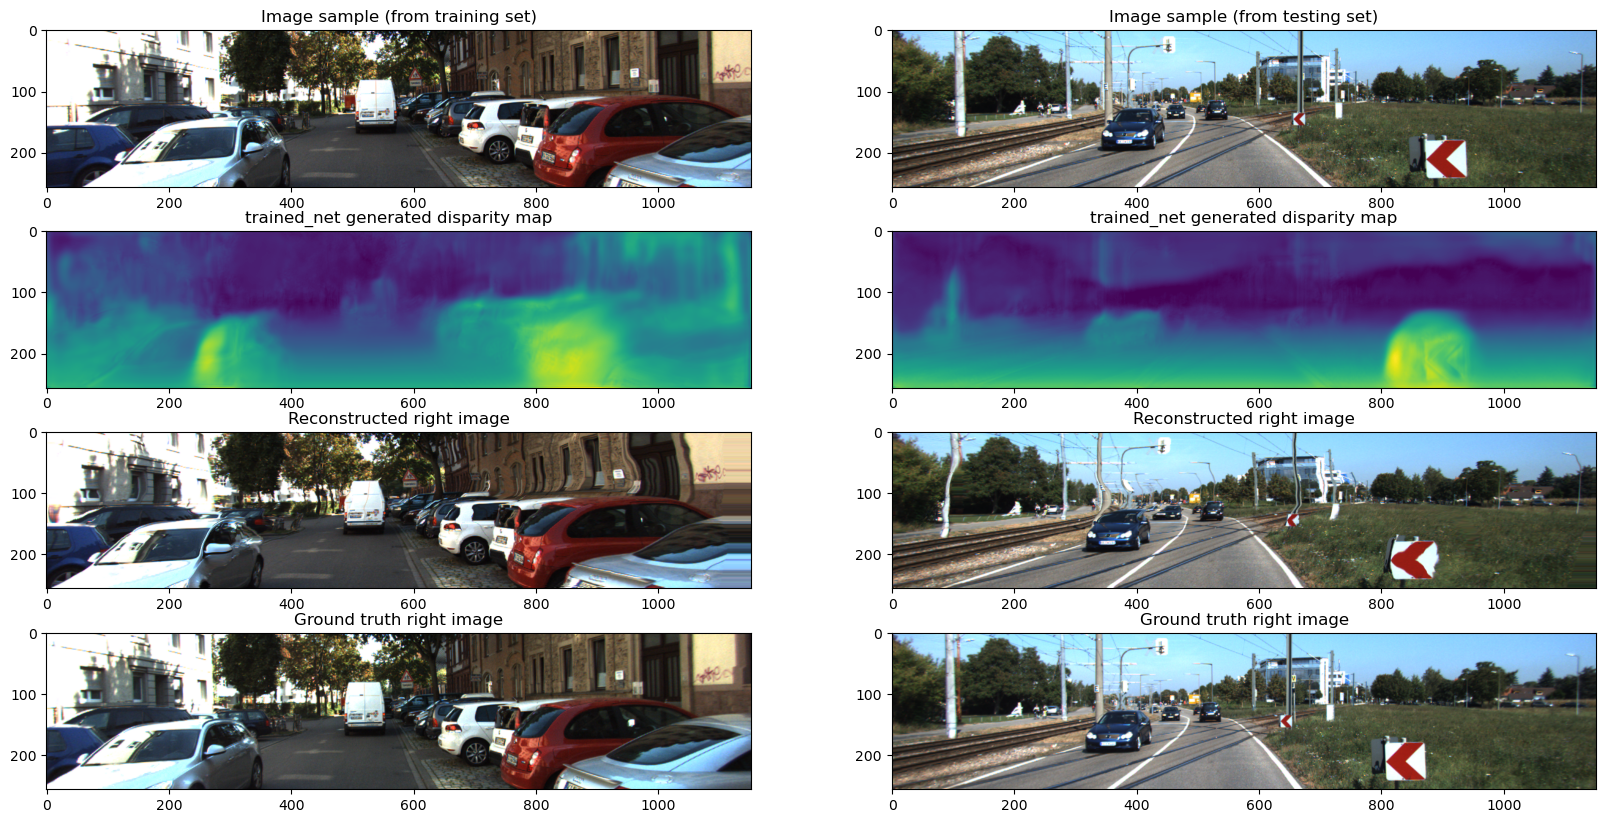

In [244]:
# ckpt = torch.load("decentmodels/firstNoTransform/trained_net.pth", weights_only=True)
# trained_net.load_state_dict(ckpt)
trained_net.eval()

im1, imR = KittiStereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([CropToMultiple(128), ToTensor()]),
)[6]

im1 = im1.cuda()

dL1 = trained_net.forward(im1[None])[0, 0]


# print(torch.min(dL1).item(), torch.max(dL1).item(), torch.mean(dL1).item(), torch.var(dL1))
# print(disparity_uniform_loss(dL1))


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(4,2,1)
plt.title('Image sample (from training set)')
ax.imshow(im1.cpu().permute(1, 2, 0).numpy())
ax = fig.add_subplot(4,2,3)
plt.title("trained_net generated disparity map")
ax.imshow(dL1.cpu().detach().numpy())
ax = fig.add_subplot(4,2,5)
plt.title("Reconstructed right image")
ax.imshow(reconStruct(im1[None].cpu().detach(), dL1[None].cpu().detach(), False)[0].permute(1, 2, 0))
ax = fig.add_subplot(4,2,7)
plt.title("Ground truth right image")
ax.imshow(imR.permute(1,2,0))


im1, imR = KittiStereo(
    DATASET_PATH, 
    split = 'test',
    transforms = JointCompose([CropToMultiple(128), ToTensor()]),
)[15]

im1 = im1.cuda()
dL1 = trained_net.forward(im1[None])[0, 0]

# print(torch.min(dL1).item(), torch.max(dL1).item(), torch.mean(dL1).item(), torch.var(dL1))
# print(""disparity_uniform_loss(dL1).item())


ax = fig.add_subplot(4,2,2)
plt.title('Image sample (from testing set)')
ax.imshow(im1.cpu().permute(1, 2, 0).numpy())
ax = fig.add_subplot(4,2,4)
plt.title("trained_net generated disparity map")
ax.imshow(dL1.cpu().detach().numpy())
ax = fig.add_subplot(4,2,6)
plt.title("Reconstructed right image")
ax.imshow(reconStruct(im1[None].cpu().detach(), dL1[None].cpu().detach(), False)[0].permute(1, 2, 0))
ax = fig.add_subplot(4,2,8)
plt.title("Ground truth right image")
ax.imshow(imR.permute(1, 2, 0))


## Evaluation

In [242]:
%%time
print("SSIM for UNTRAINED_NET over the entire dataset:{}".format(validate(val_loader, untrained_net)))

SSIM for UNTRAINED_NET over the entire dataset:0.9953323006629944
CPU times: user 22.1 s, sys: 1.64 s, total: 23.8 s
Wall time: 3.99 s


In [ ]:
%%time
print("SSIM for OVERFIT_NET over the entire dataset:{}".format(validate(val_loader, overfit_net)))

SSIM for OVERFIT_NET over the entire dataset:0.996394157409668
CPU times: user 21 s, sys: 1.57 s, total: 22.6 s
Wall time: 3.78 s


In [245]:
%%time
print("SSIM for TRAINED_NET over the entire dataset:{}".format(validate(val_loader, trained_net)))

SSIM for TRAINED_NET over the entire dataset:0.9981921315193176
CPU times: user 21.9 s, sys: 1.72 s, total: 23.6 s
Wall time: 3.96 s


## Conclusion

TODO